ENV SETUP

In [ ]:
!pip install gym_super_mario_bros==7.3.0 nes_py

In [1]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import gym
import warnings
warnings.filterwarnings('ignore')

In [2]:
# env = gym_super_mario_bros.make("SuperMarioBros-v0")
env = gym.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [ ]:
restart_game = True
for step in range(100000):
    if restart_game:
        env.reset()
    action = env.action_space.sample()
    state, reward, truncated, terminated, info = env.step(action)
    restart_game = terminated or truncated
    env.render()
env.close()

c:\users\shan\documents\projects\mario-in-python\venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\users\shan\documents\projects\mario-in-python\venv\lib\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


In [15]:
# env.close()

In [ ]:
# state = env.reset()

In [ ]:
# state

PREPROCESSING

In [ ]:
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/

In [ ]:
!pip install stable-baselines3[extra]

In [3]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

In [4]:
# 1. Create the base environment
env = gym.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human") 
# 2. Simplify the controls 
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [5]:
JoypadSpace.reset = lambda self, **kwargs: self.env.reset(**kwargs)

In [6]:
state = env.reset()

In [25]:
state, reward, done, info = env.step([5])

In [12]:
state.shape

(1, 240, 256, 4)

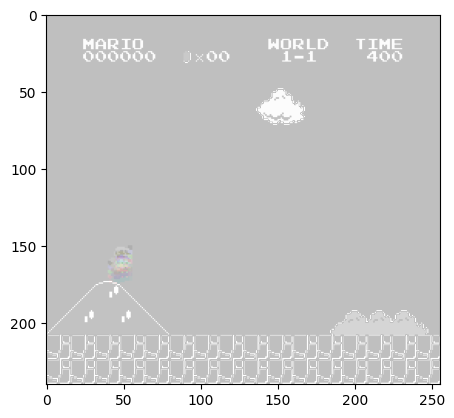

In [26]:
plt.imshow(state[0])

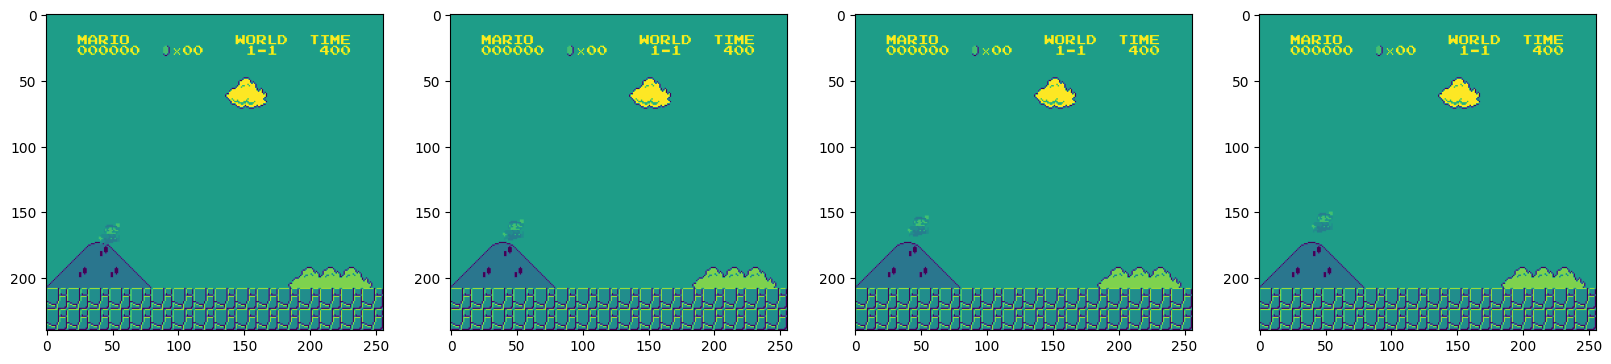

In [27]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

Train the RL Model

In [28]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [29]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [30]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [31]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [32]:
# This is the AI model started
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cpu device
Wrapping the env in a VecTransposeImage.


In [ ]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=1000000, callback=callback)

Logging to ./logs/PPO_2
----------------------------
| time/              |     |
|    fps             | 47  |
|    iterations      | 1   |
|    time_elapsed    | 10  |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 7             |
|    iterations           | 2             |
|    time_elapsed         | 134           |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 2.7265516e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.00282      |
|    learning_rate        | 1e-06         |
|    loss                 | 174           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000207     |
|    value_loss           | 472           |
-------------------------

TEST MODEL

In [ ]:
# Load model
model = PPO.load('./train/best_model_1000000')

In [ ]:
state = env.reset()

In [ ]:
state = env.reset()
# Start the game 
state = env.reset()
# Loop through the game
while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()